0.27230769230769236
0.02076923076923077
0.17857142857142858
0.010714285714285713



Wing Analysis Results:
Wing MAC length: 0.272 m
Wing MAC offset from leading edge: 0.021 m
Wing area: 0.624 m²

Tail Analysis Results:
Tail MAC length: 0.179 m
Tail MAC offset from leading edge: 0.011 m
Tail area: 0.105 m²

Tail Configuration 1 (600mm):
Tail arm (L_go): 0.633 m
Tail moment coefficient (A_go): 0.391

Tail Configuration 2 (900mm):
Tail arm (L_go): 0.933 m
Tail moment coefficient (A_go): 0.577

Neutral point positions:
Configuration 1: XNP = 0.125m = 38.3%MAC
Configuration 2: XNP = 0.151m = 47.8%MAC

Rear CG limits:
Configuration 1: 28.3%MAC
Configuration 2: 37.8%MAC


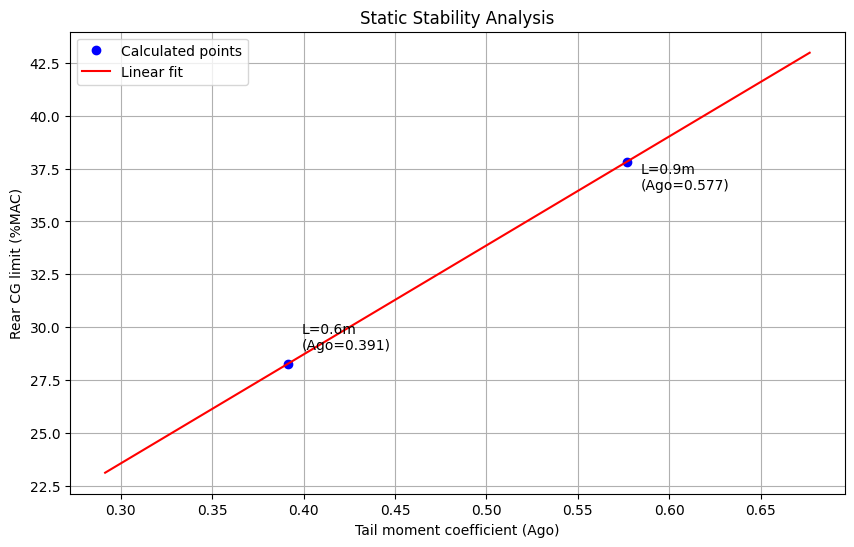

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List

def plot_stability_curve(
    ago_values: List[float],
    xt_values: List[float],
    save_path: str = None
) -> None:
    """
    Plot rear CG limit vs tail moment coefficient
    ago_values: List of tail moment coefficients
    xt_values: List of corresponding rear CG limits in %MAC
    """
    # Create figure
    plt.figure(figsize=(10, 6))

      # Plot stability curve

    # Plot points
    plt.plot(ago_values, xt_values, 'bo', label='Calculated points')

      # Add annotations for points
    plt.annotate(f'L=0.6m\n(Ago={ago_values[0]:.3f})',
                (ago_values[0], xt_values[0]),
                xytext=(10, 10), textcoords='offset points')
    plt.annotate(f'L=0.9m\n(Ago={ago_values[1]:.3f})',
                (ago_values[1], xt_values[1]),
                xytext=(10, -20), textcoords='offset points')

    # Fit line through points
    coeffs = np.polyfit(ago_values, xt_values, 1)
    x_line = np.array([min(ago_values)-0.1, max(ago_values)+0.1])
    y_line = coeffs[0] * x_line + coeffs[1]
    plt.plot(x_line, y_line, 'r-', label='Linear fit')

    # Add labels and grid
    plt.xlabel('Tail moment coefficient (Ago)')
    plt.ylabel('Rear CG limit (%MAC)')
    plt.title('Static Stability Analysis')
    plt.grid(True)
    plt.legend()

    # Save if path provided
    if save_path:
        plt.savefig(save_path)
    plt.show()

def convert_to_mac_percentage(
    xnp: float,
    bA: float,
    xA: float
) -> float:
    """
    Convert distance from nose to %MAC
    xnp: neutral point position from nose (m)
    mac_length: MAC length (m)
    mac_offset: MAC offset from nose (m)
    Returns: position in %MAC
    """
    return (xnp - xA) / bA * 100

def calculate_tail_moment_coefficient(tail_area: float, tail_arm: float,
                                      wing_area: float, mac: float) -> float:
    """Calculate tail moment coefficient (Ago)"""
    return (tail_area * tail_arm) / (wing_area * mac)

def calculate_rear_cg_limit(
    xnp: float,
    mac_length: float,
    mac_offset: float,
    static_margin: float = 0.1  # 10% MAC
) -> float:
    """
    Calculate rear CG limit based on static margin requirement
    Returns: rear CG limit in %MAC
    """
    # Convert XNP to %MAC
    xnp_mac = convert_to_mac_percentage(xnp, mac_length, mac_offset)

    # Subtract static margin
    return xnp_mac - static_margin * 100

def calculate_tail_arm(
        L:float,
        bA_wing: float,
        xA_wing: float,
        bA_tail: float,
        xA_tail: float
) -> float:

    # Position of wing's 25% MAC
    wing_25_mac = xA_wing + 0.25 * bA_wing

    # Position of tail's 25% MAC
    tail_25_mac = xA_tail + 0.25 * bA_tail

    # Tail arm is the distance between these points
    return L - tail_25_mac + wing_25_mac


def plot_stability_results(configs: List[Dict]) -> None:
    """Plot stability analysis results"""
    # Plot Ago vs rear stability limit
    ago_values = [config['Ago'] for config in configs]
    rear_limits = [config['rear_limit_mac'] for config in configs]

    plt.figure(figsize=(10, 6))
    plt.plot(ago_values, rear_limits, 'bo-')
    plt.xlabel('Tail moment coefficient (Ago)')
    plt.ylabel('Rear stability limit (% MAC)')
    plt.title('Rear Stability Limit vs Tail Moment Coefficient')
    plt.grid(True)
    plt.show()


if __name__ == "__main__":
    wing_config = {
        'root_chord': 0.3,
        'tip_chord': 0.18,
        'semi_span': 1.2,
        'rect_chord': 0.3,
        'rect_span': 0.4
    }

    Y = np.array([0, 0.4, 1.2])
    c = np.array([0.3, 0.3, 0.18])
    X = np.array([0, 0, 0.09])
    S_wing = 2 * np.trapezoid(c, Y)
    bA_wing = 2 / S_wing * np.trapezoid(c ** 2, Y)
    xA_wing = 2 / S_wing * np.trapezoid(c * X, Y)

    # Second wing section
    Y1 = np.array([0, 0.3])
    c1 = np.array([0.2, 0.15])
    X1 = np.array([0, 0.025])
    S_tail = 2 * np.trapezoid(c1, Y1)
    bA_tail = 2 / S_tail * np.trapezoid(c1 ** 2, Y1)
    xA_tail = 2 / S_tail * np.trapezoid(c1 * X1, Y1)

    # Calculate tail arm for both configurations
    tail_arm_1 = calculate_tail_arm(0.6, bA_wing, xA_wing, bA_tail, xA_tail)  # 600mm config
    tail_arm_2 = calculate_tail_arm(0.9, bA_wing, xA_wing, bA_tail, xA_tail)  # 900mm config

    # First configuration (600mm to tail leading edge)
    tail_config1 = {
        'tail_area': S_tail,
        'tail_arm': tail_arm_1,
        'mac': bA_tail,
        'x_offset': xA_tail
    }

    # Second configuration (900mm to tail leading edge)
    tail_config2 = {
        'tail_area': S_tail,
        'tail_arm': tail_arm_2,
        'mac': bA_tail,
        'x_offset': xA_tail
    }

    # Calculate tail moment coefficients
    Ago1 = calculate_tail_moment_coefficient(
        tail_config1['tail_area'],
        tail_arm_1,
        S_wing,
        bA_wing
    )

    Ago2 = calculate_tail_moment_coefficient(
        tail_config2['tail_area'],
        tail_arm_2,
        S_wing,
        bA_wing
    )

    ago_values=[Ago1, Ago2]
    # Given neutral points from XFLR5 analysis
    XNP1 = 0.125  # For Ago1 configuration
    XNP2 = 0.151  # For Ago2 configuration


    # Convert to %MAC
    xnp1_mac = convert_to_mac_percentage(XNP1, bA_wing, xA_wing)
    xnp2_mac = convert_to_mac_percentage(XNP2,  bA_wing, xA_wing)

    # Calculate rear CG limits
    rear_cg1 = calculate_rear_cg_limit(XNP1, bA_wing, xA_wing)
    rear_cg2 = calculate_rear_cg_limit(XNP2, bA_wing, xA_wing)
    xt_values = [rear_cg1, rear_cg2]

    # Print results
    print("\nWing Analysis Results:")
    print(f"Wing MAC length: {bA_wing:.3f} m")
    print(f"Wing MAC offset from leading edge: {xA_wing:.3f} m")
    print(f"Wing area: {S_wing:.3f} m²")

    # Print results
    print("\nTail Analysis Results:")
    print(f"Tail MAC length: {bA_tail:.3f} m")
    print(f"Tail MAC offset from leading edge: {xA_tail:.3f} m")
    print(f"Tail area: {S_tail:.3f} m²")

    print("\nTail Configuration 1 (600mm):")
    print(f"Tail arm (L_go): {tail_arm_1:.3f} m")
    print(f"Tail moment coefficient (A_go): {Ago1:.3f}")
    print("\nTail Configuration 2 (900mm):")
    print(f"Tail arm (L_go): {tail_arm_2:.3f} m")
    print(f"Tail moment coefficient (A_go): {Ago2:.3f}")

    print("\nNeutral point positions:")
    print(f"Configuration 1: XNP = {XNP1:.3f}m = {xnp1_mac:.1f}%MAC")
    print(f"Configuration 2: XNP = {XNP2:.3f}m = {xnp2_mac:.1f}%MAC")

    print("\nRear CG limits:")
    print(f"Configuration 1: {rear_cg1:.1f}%MAC")
    print(f"Configuration 2: {rear_cg2:.1f}%MAC")

    plot_stability_curve(ago_values, xt_values, 'stability_plot.png')
